In [2]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/summary-100/Golden_summary - Copy.xlsx
/kaggle/input/summary-20/Golden_summary - Copy.xlsx


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Training Loss: 4.3687
Epoch 1 - Validation Loss: 1.7218
Epoch 2 - Training Loss: 1.9105
Epoch 2 - Validation Loss: 1.2152
Epoch 3 - Training Loss: 1.1478
Epoch 3 - Validation Loss: 1.0035
Epoch 4 - Training Loss: 0.7119
Epoch 4 - Validation Loss: 0.9055
Epoch 5 - Training Loss: 0.5082
Epoch 5 - Validation Loss: 0.8899


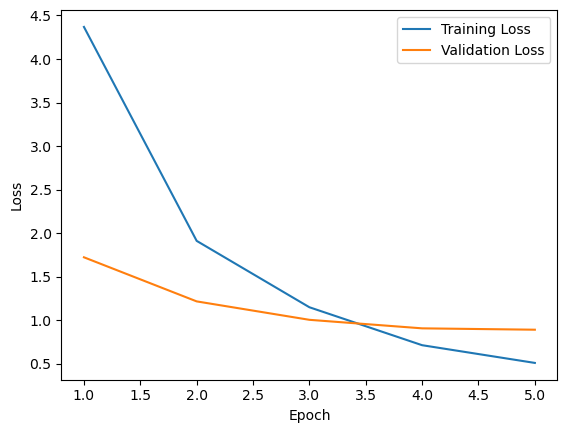

Target:  "The appellant is a share broker carrying on business in the City of Bombay and a member of the Native Share and Stock Brokers' Association, Bombay. The respondent employed him for effecting sales and purchases of shares on her behalf and on 6-8-1947 there was due from her to the appellant on account of these dealings a sum of Rs. 6,321-12-0. On 11-8-1947, the appellant effected purchases of 25 shares of Tata Deferred and 350 shares of Swadeshi Mills to square the outstanding sales of the respondent, and sent the relative contract notes therefor Nos. 2438 and 2439 (Exhibit A) to her. The dispute between the parties is as to whether the appellant was acting within the scope of his authority when he purchased 25 shares of Tata Deferred and 350 shares of Swadeshi Mills on 11-8-1947.The Court finds that there was an agreement in writing for disputes arising out of the respondent's employment as broker to be referred to arbitration. Contracts regulated by Rules 359 to 363 cannot be

In [4]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
import matplotlib.pyplot as plt

def generate_prediction(model, tokenizer, input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=None, truncation=True)
    input_ids = input_ids.to(device)

    outputs = model.generate(input_ids=input_ids, max_length=50, num_beams=4, early_stopping=True)
    predictions = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return predictions

# Step 1: Load the Dataset
df = pd.read_excel("/kaggle/input/summary-100/Golden_summary - Copy.xlsx")

# Step 2: Split the Dataset into Train, Test, and Validation Sets
train_text, test_text, train_summary, test_summary = train_test_split(
    df['Judgment'], df['Golden summary'], test_size=0.2, random_state=42
)
test_text, val_text, test_summary, val_summary = train_test_split(
    test_text, test_summary, test_size=0.5, random_state=42
)

tokenizer = AutoTokenizer.from_pretrained("nsi319/legal-led-base-16384")
model = AutoModelForSeq2SeqLM.from_pretrained("nsi319/legal-led-base-16384")

# Step 4: Tokenize the Data
train_encodings = tokenizer(list(train_text), truncation=True, padding=True)
train_labels = tokenizer(list(train_summary.astype(str)), truncation=True, padding=True)

val_encodings = tokenizer(list(val_text), truncation=True, padding=True)
val_labels = tokenizer(list(val_summary.astype(str)), truncation=True, padding=True)

test_encodings = tokenizer(list(test_text), truncation=True, padding=True)
test_labels = tokenizer(list(test_summary.astype(str)), truncation=True, padding=True)

# Step 5: Create PyTorch Datasets
class SummaryDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])
        return item

    def __len__(self):
        return len(self.labels['input_ids'])

train_dataset = SummaryDataset(train_encodings, train_labels)
val_dataset = SummaryDataset(val_encodings, val_labels)
test_dataset = SummaryDataset(test_encodings, test_labels)

# Step 6: Fine-tune the T5 Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

optimizer = AdamW(model.parameters(), lr=1e-5)

num_epochs = 5

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Training Loss: {avg_loss:.4f}")

    # Step 7: Evaluation on Validation Set
    model.eval()

    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")

# Plotting the losses
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 8: Generate Predictions on Test Set
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=50)
        batch_preds = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
        predictions.extend(batch_preds)

# Step 9: Evaluate Predictions
test_summary_list = test_summary.tolist()

for i in range(len(predictions)):
    print(f"Target: {test_summary_list[i]}")
    print(f"Prediction: {predictions[i]}")
    print("=" * 5)


In [12]:
# Step 8: Generate Predictions on Test Set
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=200)
        batch_preds = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
        predictions.extend(batch_preds)


# Step 9: Evaluate Predictions
test_summary_list = test_summary.tolist()

for i in range(len(predictions)):
    print(f"Target: {test_summary_list[i]}")
    print(f"Prediction: {predictions[i]}")
    print("=" * 5)
    

Target:  "The appellant is a share broker carrying on business in the City of Bombay and a member of the Native Share and Stock Brokers' Association, Bombay. The respondent employed him for effecting sales and purchases of shares on her behalf and on 6-8-1947 there was due from her to the appellant on account of these dealings a sum of Rs. 6,321-12-0. On 11-8-1947, the appellant effected purchases of 25 shares of Tata Deferred and 350 shares of Swadeshi Mills to square the outstanding sales of the respondent, and sent the relative contract notes therefor Nos. 2438 and 2439 (Exhibit A) to her. The dispute between the parties is as to whether the appellant was acting within the scope of his authority when he purchased 25 shares of Tata Deferred and 350 shares of Swadeshi Mills on 11-8-1947.The Court finds that there was an agreement in writing for disputes arising out of the respondent's employment as broker to be referred to arbitration. Contracts regulated by Rules 359 to 363 cannot be

In [13]:
model_save_path = "/kaggle/working/Legal Led base_model_gsd.h5"
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /kaggle/working/Legal Led base_model_gsd.h5


In [14]:
!pip install rouge
from rouge import Rouge

references = []
hypotheses = []

for i in range(len(predictions)):
    reference = test_summary_list[i]
    hypothesis = predictions[i]
    references.append(reference)
    hypotheses.append(hypothesis)

rouge = Rouge()
scores = rouge.get_scores(hypotheses, references, avg=True)

rouge_1_score = scores['rouge-1']
rouge_2_score = scores['rouge-2']
rouge_l_score = scores['rouge-l']

print(f"ROUGE-1 Score: {rouge_1_score}")
print(f"ROUGE-2 Score: {rouge_2_score}")
print(f"ROUGE-L Score: {rouge_l_score}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ROUGE-1 Score: {'r': 0.4501536581967985, 'p': 0.604388555704577, 'f': 0.5036624716598653}
ROUGE-2 Score: {'r': 0.3294066924599979, 'p': 0.4376482156487307, 'f': 0.3647751814439762}
ROUGE-L Score: {'r': 0.43629676283752605, 'p': 0.5858110517948407, 'f': 0.48815303286115286}


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

references = test_summary_list
hypotheses = predictions


tfidf_vectorizer = TfidfVectorizer()
vectorized_references = tfidf_vectorizer.fit_transform(references)
vectorized_hypotheses = tfidf_vectorizer.transform(hypotheses)


cosine_similarities = cosine_similarity(vectorized_references, vectorized_hypotheses)


average_cosine_similarity = np.mean(cosine_similarities)


print(f"Average Cosine Similarity: {average_cosine_similarity:.4f}")


Average Cosine Similarity: 0.4151
